In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from ANEMO import read_edf
import numpy as np
from lmfit import  Model, Parameters
%matplotlib inline

In [2]:
!ls ../data/

enregistrement_AM_2017-10-23_100057.asc
enregistrement_AM_2017-10-23_100057.edf
enregistrement_AM_2017-10-23_100057.pkl
enregistrement_BMC_2017-09-26_095637.asc
enregistrement_BMC_2017-09-26_095637.EDF
enregistrement_BMC_2017-09-26_095637.pkl
enregistrement_CS_2017-10-03_134421.asc
enregistrement_CS_2017-10-03_134421.edf
enregistrement_CS_2017-10-03_134421.pkl
enregistrement_DC_2017-09-27_161040.asc
enregistrement_DC_2017-09-27_161040.edf
enregistrement_DC_2017-09-27_161040.pkl
enregistrement_FM_2017-10-03_143803.asc
enregistrement_FM_2017-10-03_143803.EDF
enregistrement_FM_2017-10-03_143803.pkl
enregistrement_IP_2017-09-28_115250.asc
enregistrement_IP_2017-09-28_115250.edf
enregistrement_IP_2017-09-28_115250.pkl
enregistrement_LB_2017-09-20_151043 (1).asc
enregistrement_LB_2017-09-20_151043.asc
enregistrement_LB_2017-09-20_151043.edf
enregistrement_LB_2017-09-20_151043.pkl
enregistrement_OP_2017-10-26_121823.asc
enregistrement_OP_2017-10-26_121823.edf
enregistrement_OP_2017-10-26_1218

In [3]:
timeStr = '2017-10-03_134421'
observer = 's03'
mode = 'eyeMvt'

In [4]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [6]:
def exponentiel (x, tau, maxi, start_anti, a_anti, latency, bino) :
    '''
    tau -- courbe
    maxi -- maximum
    latency -- tps où commence le mvt
    bino -- binomial
    
    start_anti = debut de l'anticipation
    a_anti =  vitesse de l'anticipation
    ''' 
    a_anti = a_anti/1000 # pour passer de sec à ms
    time = np.arange(len(x))
    vitesse = []
                
    for t in range(len(time)):
        
        if start_anti >= latency :
            if time[t] < latency :
                vitesse.append(0)
            else :
                vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latency))))
        else :

            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latency :
                    #vitesse.append((bino*2-1)*(time[t]-start_anti)*a_anti)
                    vitesse.append((time[t]-start_anti)*a_anti)
                    x = (time[t]-start_anti)*a_anti
                else :
                    vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latency)))+x)
    return vitesse

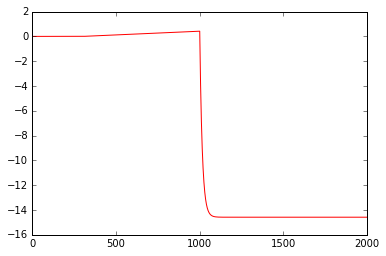

In [7]:
plt.plot(exponentiel(np.arange(2000), tau=15, maxi=15., start_anti=300, latency=1000., a_anti=0.6, bino=0), c='r')

882
1113
[1898]


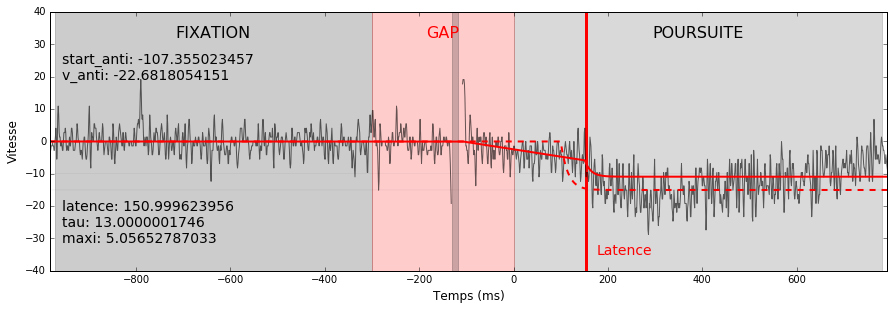

[[Model]]
    Model(exponentiel)
[[Fit Statistics]]
    # function evals   = 141
    # data points      = 1875
    # variables        = 5
    chi-square         = 52196.825
    reduced chi-square = 27.913
    Akaike info crit   = 6247.024
    Bayesian info crit = 6274.706
[[Variables]]
    tau:          13.0000001 +/- 10.35983 (79.69%) (init= 15)
    maxi:         5.05652787 +/- 0.686419 (13.57%) (init= 15)
    latency:      1163.99962 +/- 7.205149 (0.62%) (init= 1113)
    start_anti:   905.644976 +/- 28.97928 (3.20%) (init= 913)
    a_anti:      -22.6818054 +/- 4.416340 (19.47%) (init=-0)
    bino:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(start_anti, a_anti)        = -0.866 
    C(maxi, a_anti)              =  0.827 
    C(tau, latency)              = -0.659 
    C(maxi, start_anti)          = -0.476 
    C(maxi, latency)             = -0.242 
    C(latency, a_anti)           = -0.202 
    C(latency, start_anti)       =  0.117 



/usr/local/lib/python3.5/dist-packages/lmfit/printfuncs.py:140: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))


In [8]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
block = 0
trial = 154

trial_data = trial + N_trials*block

data_x = data[trial_data]['x']
data_y = data[trial_data]['y']
trackertime = data[trial_data]['trackertime']

StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']
trackertime_0 = data[trial_data]['trackertime'][0]

gradient_x = np.gradient(data_x) # gradient en px/ms
gradient_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec

##################################################
# SUPPRESSION DES SACCADES
##################################################
gradient_deg_NAN = []
for x_data in range(len(data_x)):
    saccade = None

    for s in range(len(saccades)) :
        if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+10)) :
            gradient_deg_NAN.append(np.nan)#gradient_deg_NAN[x_data-1])#'nan')
            saccade = 'yes'
    if not saccade :
        gradient_deg_NAN.append(gradient_deg[x_data])
    saccade = None

nini = []    
for s in range(len(saccades)) :
    if (saccades[s][0]-trackertime_0) >= (TargetOn-trackertime_0+100) :
        nini.append((saccades[s][0]-trackertime_0))
if nini==[] :
    nini.append(len(trackertime))
print(saccades[0][0]-trackertime_0)
print(TargetOn-trackertime_0+100)
print(nini)
##################################################

start = TargetOn

StimulusOn_s = StimulusOn - start
StimulusOf_s = StimulusOf - start
TargetOn_s = TargetOn - start
TargetOff_s = TargetOff - start
trackertime_s = trackertime - start

# FIT
model = Model(exponentiel)
bino=p[trial, block, 0]
params = Parameters()

params.add('tau', value=15., min=13., max=80.)#, vary=False)
params.add('maxi', value=15., min=1., max=40.)#, vary=False)
params.add('latency', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0+50, max=nini[0])
params.add('start_anti', value=TargetOn-trackertime_0-100, min=StimulusOf-trackertime_0+100, max=TargetOn-trackertime_0-50)
params.add('a_anti', value=(bino*2-1)*0, min=-40., max=40.)
params.add('bino', value=bino, min=0, max=1, vary=False)

#result_deg = model.fit(new_gradient_deg, params, x=new_time)
result_deg = model.fit(gradient_deg_NAN, params, x=trackertime, fit_kws={'nan_policy': 'omit'})

debut  = TargetOn - trackertime_0 # TargetOn - temps_0

axs.axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])

axs.plot(trackertime_s, gradient_deg_NAN, color='k', alpha=0.6)
axs.plot(trackertime_s, result_deg.init_fit, 'r--', linewidth=2)
axs.plot(trackertime_s, result_deg.best_fit, color='r', linewidth=2)
axs.plot(trackertime_s, np.ones(np.shape(trackertime_s)[0])*(bino*2-1)*15, color='k', linewidth=0.2, alpha=0.2)
axs.plot(trackertime_s, np.ones(np.shape(trackertime_s)[0])*(bino*2-1)*10, color='k', linewidth=0.2, alpha=0.2)


axs.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
axs.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
axs.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)
for s in range(len(saccades)) :
    axs.axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

start_anti = result_deg.values['start_anti']-debut
a_anti = result_deg.values['a_anti']
latency = result_deg.values['latency']-debut
tau = result_deg.values['tau']
maxi = result_deg.values['maxi']

axs.bar(latency, 80, bottom=-40, color='r', width=6, linewidth=0)

axs.text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 31, "FIXATION", color='k', fontsize=16, ha='center', va='bottom')
axs.text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 31, "GAP", color='r', fontsize=16, ha='center', va='bottom')
axs.text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 31, "POURSUITE", color='k', fontsize=16, ha='center', va='bottom')
axs.text(latency+25, -35, "latency", color='r', fontsize=14)#,  weight='bold')
axs.text(StimulusOn_s+15, 18, "start_anti: %s \na_anti: %s"%(start_anti, a_anti), color='k', fontsize=14, va='bottom')
axs.text(StimulusOn_s+15, -18, "latency: %s \ntau: %s \nmaxi: %s"%(latency, tau, maxi), color='k', fontsize=14, va='top')

axs.set_xlabel('Temps (ms)', fontsize=12)
axs.set_ylabel('Vitesse', fontsize=12)
plt.show()
print(result_deg.fit_report())